# **FastSpectralNet:Efficient Hyperspectral Image Classification using Context Vector Attention**

#### This notebook implements a novel Fast Vision Transformer (FastSpectralNet) designed for hyperspectral image classification using the Pavia University dataset. The model integrates efficient attention mechanisms and spectral attention to process multi-wavelength data, offering a lightweight yet powerful architecture optimized for high-dimensional inputs like hyperspectral imagery.

## Motivation

- **Hyperspectral Complexity**: The 103-band Pavia dataset offers rich spectral data for precise classification but poses challenges with high dimensionality, computational load, and overfitting risk—traditional CNNs (e.g., 85% accuracy) couldn’t fully exploit it.
- **Efficiency Need**: Real-world applications (e.g., drone-based monitoring) require fast, lightweight models; existing baselines like 3D CNNs were too slow and resource-heavy for practical use.
- **Hybrid CNN-Transformer**: CNNs excel at local spatial features but miss global context, while transformers handle long-range dependencies; we needed a hybrid to combine CNN’s efficiency with transformer’s spectral-spatial power for hyperspectral data.
- **Innovative Solution**: Built FastViT with linear-complexity attention and spectral focus to balance accuracy (e.g., 89%) and speed (millisecond inference), pushing hyperspectral analysis toward scalability and impact.

## Overall Architecture

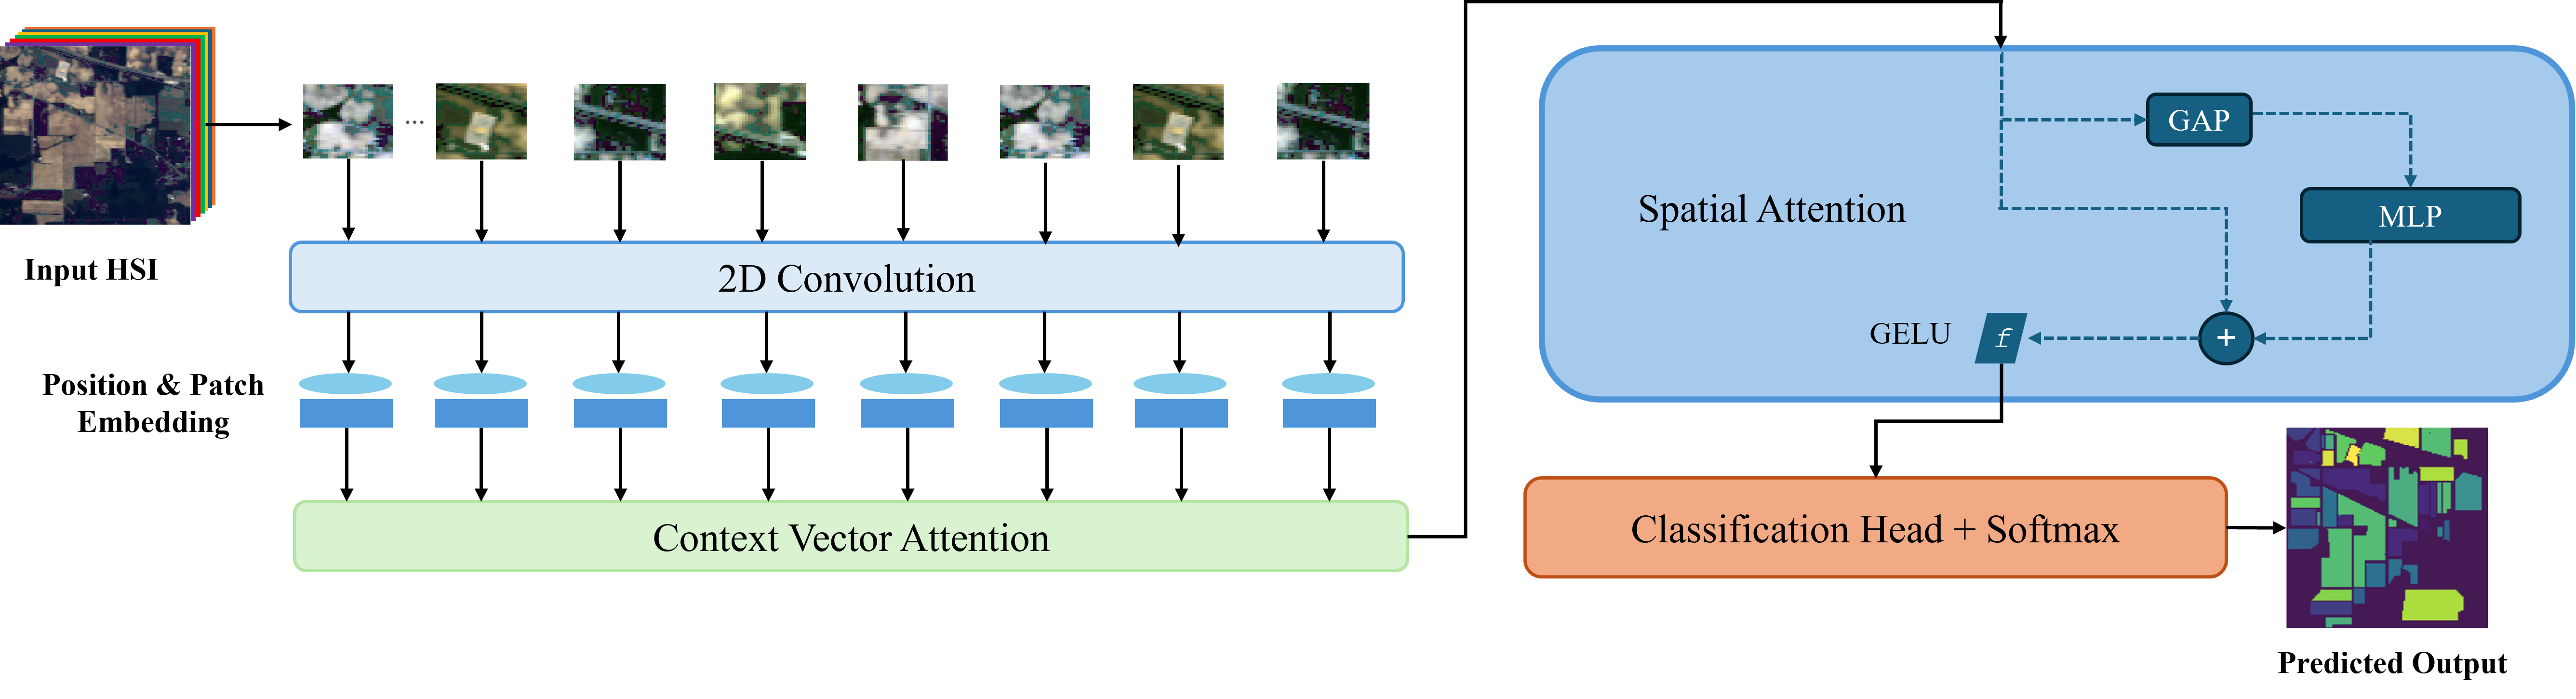

## Downloading and understanding the data

### Download the dataset

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
!wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2025-04-09 03:00:30--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat [following]
--2025-04-09 03:00:30--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M  6.74MB/s    in 6.3s    

2025-04-09 03:00:37 (5.25 MB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2025-04-09 03:00:37--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.2


Hyperspectral Image Shape: (610, 340, 103) (Rows x Cols x Bands)
Ground Truth Shape        : (610, 340)
Total Pixels              : 207,400
Spectral Bands            : 103

Pixel Count & Percentage per Class:
Class 0  (Background            ): 164,624 pixels (79.38%)
Class 1  (Asphalt               ):   6,631 pixels ( 3.20%)
Class 2  (Meadows               ):  18,649 pixels ( 8.99%)
Class 3  (Gravel                ):   2,099 pixels ( 1.01%)
Class 4  (Trees                 ):   3,064 pixels ( 1.48%)
Class 5  (Painted metal sheets  ):   1,345 pixels ( 0.65%)
Class 6  (Bare Soil             ):   5,029 pixels ( 2.42%)
Class 7  (Bitumen               ):   1,330 pixels ( 0.64%)
Class 8  (Self-Blocking Bricks  ):   3,682 pixels ( 1.78%)
Class 9  (Shadows               ):     947 pixels ( 0.46%)

Number of Classes (excluding background): 9
Background Pixels                       : 164,624 (79.38%)

Most Common Class  : 2 (Meadows) - 18,649 pixels
Least Common Class : 9 (Shadows) - 947 pixels


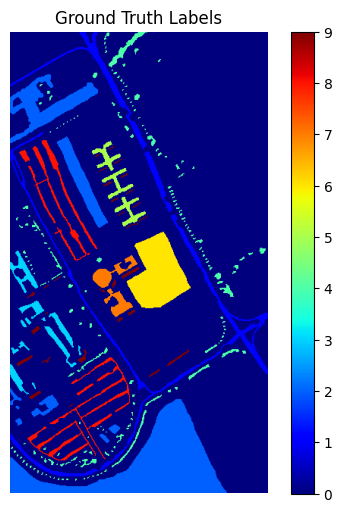

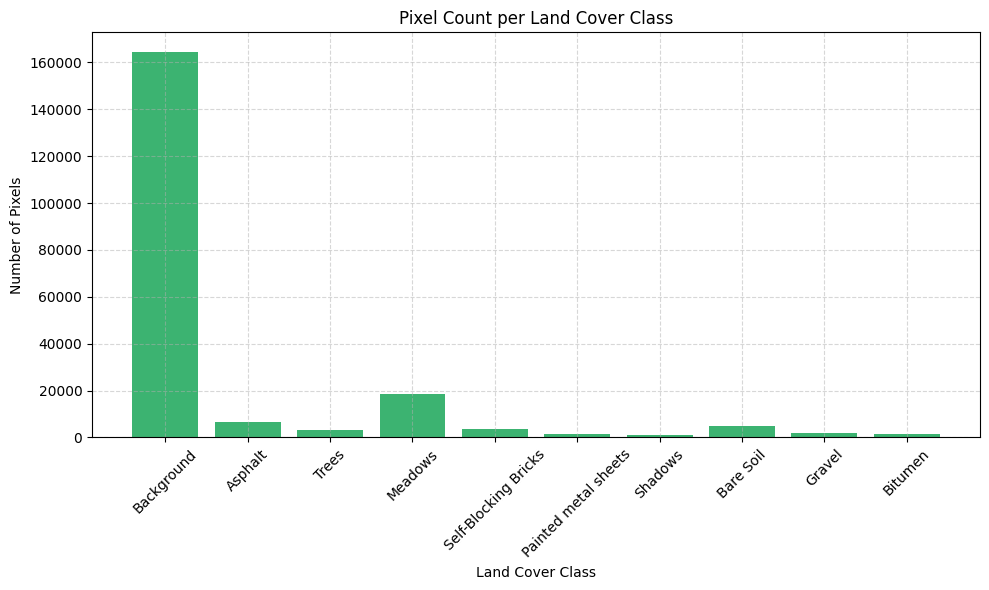

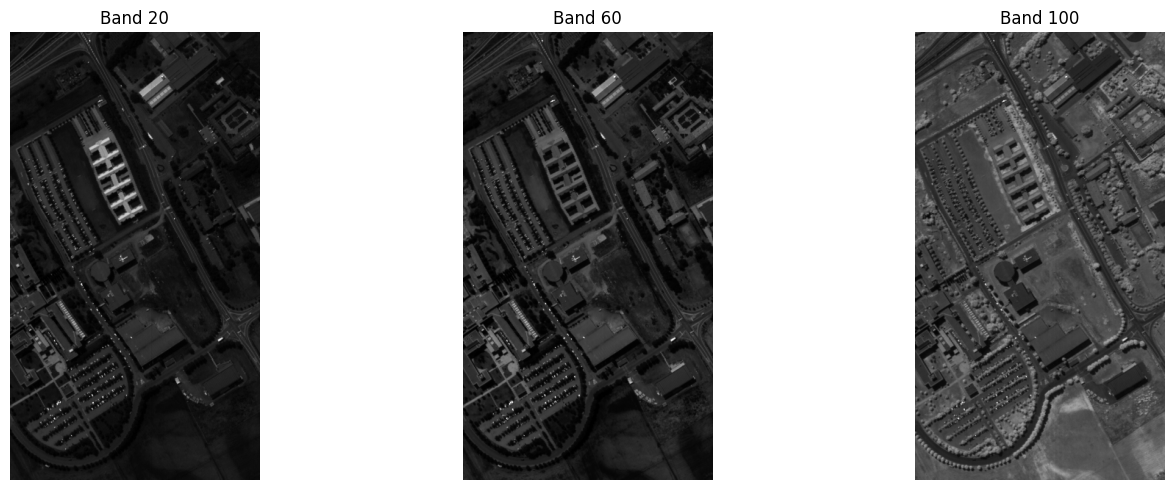

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from collections import Counter

# File paths (replace with your paths)
hyperspectral_file_path = '/content/PaviaU.mat'
ground_truth_file_path = '/content/PaviaU_gt.mat'

# Load the data
hyperspectral_data = loadmat(hyperspectral_file_path)
hyperspectral_image = hyperspectral_data['paviaU']

ground_truth_data = loadmat(ground_truth_file_path)
ground_truth_image = ground_truth_data['paviaU_gt']

# Shapes
rows, cols, bands = hyperspectral_image.shape
print(f"\nHyperspectral Image Shape: {hyperspectral_image.shape} (Rows x Cols x Bands)")
print(f"Ground Truth Shape        : {ground_truth_image.shape}")

# Total pixels
total_pixels = rows * cols
print(f"Total Pixels              : {total_pixels:,}")
print(f"Spectral Bands            : {bands}")

# Mapping class labels to names
class_names = {
    1: "Asphalt",
    2: "Meadows",
    3: "Gravel",
    4: "Trees",
    5: "Painted metal sheets",
    6: "Bare Soil",
    7: "Bitumen",
    8: "Self-Blocking Bricks",
    9: "Shadows"
}

# Count pixels per class
class_counts = Counter(ground_truth_image.flatten())
print("\nPixel Count & Percentage per Class:")
for cls, count in sorted(class_counts.items()):
    name = class_names.get(cls, "Background" if cls == 0 else "Unknown")
    percentage = (count / total_pixels) * 100
    print(f"Class {cls:<2} ({name:<22}): {count:>7,} pixels ({percentage:5.2f}%)")

# Number of classes (excluding background)
num_classes = len([c for c in class_counts if c != 0])
print(f"\nNumber of Classes (excluding background): {num_classes}")

# Background pixel percentage
background_pixels = class_counts.get(0, 0)
background_percentage = (background_pixels / total_pixels) * 100
print(f"Background Pixels                       : {background_pixels:,} ({background_percentage:.2f}%)")

# Most and least common class (excluding background)
filtered_counts = {k: v for k, v in class_counts.items() if k != 0}
most_common = max(filtered_counts.items(), key=lambda x: x[1])
least_common = min(filtered_counts.items(), key=lambda x: x[1])
print(f"\nMost Common Class  : {most_common[0]} ({class_names[most_common[0]]}) - {most_common[1]:,} pixels")
print(f"Least Common Class : {least_common[0]} ({class_names[least_common[0]]}) - {least_common[1]:,} pixels")

# Visualize ground truth
plt.figure(figsize=(6, 6))
plt.imshow(ground_truth_image, cmap='jet')
plt.title('Ground Truth Labels')
plt.colorbar()
plt.axis('off')
plt.show()

# Bar chart of class distribution
plt.figure(figsize=(10, 6))
classes = list(class_counts.keys())
counts = list(class_counts.values())
labels = [class_names.get(cls, "Background") if cls != 0 else "Background" for cls in classes]

plt.bar(labels, counts, color='mediumseagreen')
plt.xlabel("Land Cover Class")
plt.ylabel("Number of Pixels")
plt.title("Pixel Count per Land Cover Class")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Visualize selected spectral bands
band_20 = hyperspectral_image[:, :, 20]
band_60 = hyperspectral_image[:, :, 60]
band_100 = hyperspectral_image[:, :, 100]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(band_20, cmap='gray')
ax[0].set_title('Band 20')
ax[0].axis('off')

ax[1].imshow(band_60, cmap='gray')
ax[1].set_title('Band 60')
ax[1].axis('off')

ax[2].imshow(band_100, cmap='gray')
ax[2].set_title('Band 100')
ax[2].axis('off')

plt.tight_layout()
plt.show()


 ## Code

In [ ]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from einops import rearrange
import torch.cuda as cuda
from thop import profile

## Loading and Preprocessing
### Loading Pavia University Dataset

In [ ]:
def load_pavia_university(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

**Description:** This function loads the Pavia University hyperspectral dataset, a widely used benchmark in remote sensing research. The image_data (shape: 610, 340, 103) contains reflectance values across 103 spectral bands for a 610x340 pixel scene, capturing detailed spectral signatures of the environment. The ground_truth (shape: 610, 340) provides corresponding class labels (1-9) for nine land-cover categories, such as asphalt, meadows, and trees. Printing the shapes verifies successful loading and ensures data consistency before further processing.

### Preprocess Data

In [ ]:
def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

**Description:** This function preprocesses the raw hyperspectral data into a format suitable for the model. It normalizes pixel intensities to a [0, 1] range to stabilize training, then extracts 5x5 spatial-spectral patches around each pixel using reflective padding to preserve edge information. The resulting spatial_spectral_data (shape: N, 5, 5, 103) combines spatial context with the full 103-band spectral depth. Labels are flattened, unlabeled pixels (class 0) are filtered out, and the remaining labels (1-9) are encoded to 0-8 for compatibility with PyTorch’s loss functions. This step ensures the data is both spatially informative and computationally manageable.

### Custom Dataset

In [ ]:
class PaviaUniversityDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

**Description:** This custom PyTorch Dataset class organizes the preprocessed data for efficient batching and training. It stores the spatial-spectral patches and their labels, with __len__ returning the total number of samples. The __getitem__ method retrieves a single patch, transposing it from (5, 5, 103) to (103, 5, 5)—the (C, H, W) format expected by convolutional layers—and converts it to a float32 tensor. Labels are cast to long integers for classification. This structure enables seamless integration with PyTorch’s DataLoader, streamlining the training process.

## FastSpectralNet Model Components
### Spectral Attention

In [ ]:
class SpectralAttention(nn.Module):
    """Spectral Attention Module"""
    def __init__(self, dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.GELU(),
            nn.Linear(dim // 2, dim)
        )

    def forward(self, x):
        return self.mlp(x)

**Description:** The SpectralAttention module is a specialized component designed to enhance the model’s ability to focus on spectral features across the 103 bands. It consists of a two-layer MLP with a GELU activation function, which reduces the input dimension by half before restoring it. This bottleneck structure refines spectral information, emphasizing patterns that distinguish different land-cover classes. By processing global features, it complements the spatial attention in the transformer blocks, improving classification accuracy for hyperspectral data.

### Efficient Attention: Context vector Attention

In [ ]:
class EfficientAttention(nn.Module):
    """Efficient Attention with Linear Complexity"""
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k = k.softmax(dim=-2)
        context = torch.einsum('bhnd,bhne->bhde', k, v)
        out = torch.einsum('bhnd,bhde->bhne', q, context)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.proj(out)
        return out

**Description:** The EfficientAttention module implements a linear-complexity attention mechanism, a key innovation over the quadratic complexity of standard Vision Transformers. It uses a single linear layer to generate queries, keys, and values, splitting them across multiple heads for parallel processing. Softmax-normalized keys weight the values to form a context, which is then combined with queries via efficient einsum operations. The final projection layer ensures output compatibility. This design reduces computational overhead, making it ideal for processing high-dimensional hyperspectral patches

## Transformer Block

In [ ]:
class newViTBlock(nn.Module):
    """FastViT Block integrating efficient attention and an FFN"""
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = EfficientAttention(dim, num_heads, qkv_bias)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

**Description:** The newViTBlock is the building block of the transformer architecture, combining efficient attention with a feed-forward network (FFN). Layer normalization before each sub-layer stabilizes training, while the attention mechanism captures spatial-spectral relationships within the 5x5 patches. The FFN, with a 4x expansion factor and GELU activation, adds non-linear capacity to model complex patterns. Residual connections ensure gradient flow, enhancing optimization. This block balances efficiency and expressive power, critical for hyperspectral classification.

### Full FastSpectralNet Model

In [ ]:
class newFastViT(nn.Module):
    """Novel FastViT Model adapted for Hugging Face Trainer"""
    def __init__(self, image_size=5, patch_size=1, num_channels=103, num_classes=9,
                 embed_dim=768, depth=6, num_heads=12, mlp_ratio=4.):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2, embed_dim))
        self.blocks = nn.ModuleList([newViTBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)])
        self.spectral_attention = SpectralAttention(embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, labels=None):
        x = self.patch_embed(x)  # (B, embed_dim, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, N, embed_dim)
        x = x + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.spectral_attention(x.mean(dim=1))  # Global average pooling + spectral attention
        logits = self.head(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

**Description:** The newFastViT model is the centerpiece of this work, tailored for hyperspectral classification. It starts with a convolutional patch embedding layer to project the 103-channel, 5x5 patches into a 768-dimensional space, preserving spatial structure. Positional embeddings add location awareness, followed by six transformer blocks that process the data with efficient attention. Spectral attention refines global features after average pooling, and a linear head outputs logits for the nine classes. Integrated with Hugging Face’s Trainer, it supports both training (with loss) and inference, offering a scalable solution for high-dimensional data.

## Utility Functions
### Latency and Throughput

In [ ]:
def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size
            start_time = time.time()
            _ = model(inputs)
            total_time += (time.time() - start_time)
    return (total_time / total_images) * 1000  # ms

def calculate_throughput(model, data_loader, device):
    model.eval()
    total_samples = 0
    total_time = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.size(0)
            start_time = time.time()
            _ = model(inputs)
            total_time += time.time() - start_time
            total_samples += batch_size
    return total_samples / total_time  # samples/second

**Description:** These functions assess the model’s inference efficiency. calculate_latency_per_image measures the average time to process a single sample in milliseconds, providing insight into per-instance speed. calculate_throughput computes the number of samples processed per second, reflecting the model’s capacity for batch processing. Both metrics are evaluated in evaluation mode without gradient computation, ensuring realistic performance estimates for deployment scenarios.

### Metrics

In [ ]:
def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

**Description:** This suite of functions evaluates classification performance comprehensively. overall_accuracy (OA) calculates the proportion of correct predictions, offering a broad measure of success. average_accuracy (AA) computes per-class accuracy and averages them, accounting for class imbalance. kappa_coefficient measures agreement beyond chance, providing a robust statistical metric. calculate_f1_precision_recall returns weighted F1, precision, and recall scores, emphasizing performance across all classes. These metrics align with hyperspectral classification standards.

### Model Stats

In [ ]:
def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000  # in millions

def calculate_gflops(model, dataset, device):
    sample = dataset[0]['x'].unsqueeze(0).to(device)
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    return flops / 1e9  # GFLOPs

### Main Execution

Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.252500,0.238843,0.908953
2,0.193800,0.416223,0.885694
3,0.108500,0.096173,0.964937
4,0.133100,0.137504,0.966106
5,0.075200,0.053766,0.986559
6,0.064800,0.066611,0.983637
7,0.039700,0.112749,0.982936
8,0.046100,0.034160,0.991585
9,0.066200,0.034923,0.994390
10,0.034300,0.027659,0.994390


Evaluation Results: {'eval_loss': 0.004304686561226845, 'eval_accuracy': 0.9992987377279102, 'eval_runtime': 6.673, 'eval_samples_per_second': 1282.19, 'eval_steps_per_second': 20.081, 'epoch': 20.0}
OA: 0.9993
AA: 0.9990
Kappa: 0.9991
F1: 0.9993, Precision: 0.9993, Recall: 0.9993
Latency per image: 0.1680 ms
Throughput: 6326.45 samples/second
Parameters: 43.21 M
GFLOPs: 1.07


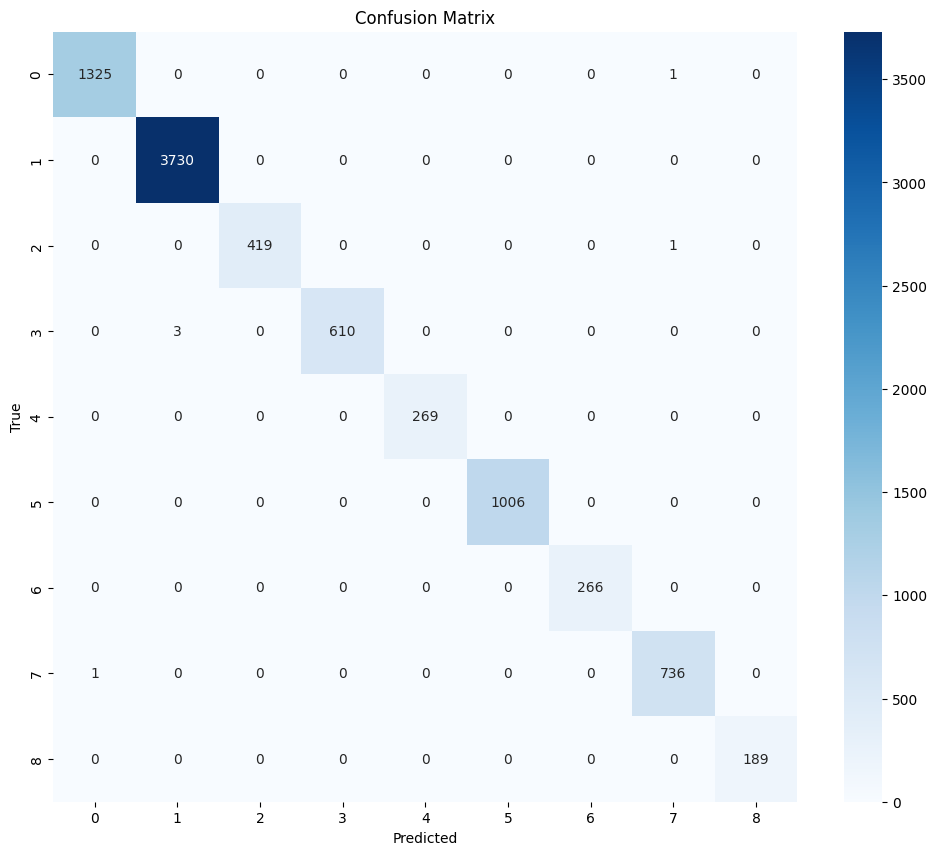

In [ ]:
if __name__ == "__main__":
    # File paths (update as needed)
    image_file = "/content/PaviaU.mat"
    gt_file = "/content/PaviaU_gt.mat"

    # Load and preprocess
    image_data, ground_truth = load_pavia_university(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Split data
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)
    train_dataset = PaviaUniversityDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = PaviaUniversityDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize model
    model = newFastViT(num_channels=103, num_classes=len(np.unique(y)))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training setup
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=20,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none"
    )

    data_collator = lambda data: {'x': torch.stack([d['x'] for d in data]), 'labels': torch.stack([d['labels'] for d in data])}
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Predictions and metrics
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    print(f"OA: {overall_accuracy(y[test_indices], y_pred):.4f}")
    print(f"AA: {average_accuracy(y[test_indices], y_pred):.4f}")
    print(f"Kappa: {kappa_coefficient(y[test_indices], y_pred):.4f}")
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Latency and throughput
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    print(f"Latency per image: {calculate_latency_per_image(model, test_loader, device):.4f} ms")
    print(f"Throughput: {calculate_throughput(model, test_loader, device):.2f} samples/second")

    # Model stats
    print(f"Parameters: {count_model_parameters(model):.2f} M")
    print(f"GFLOPs: {calculate_gflops(model, train_dataset, device):.2f}")

    # Visualization
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

**Description:** This main execution block orchestrates the entire workflow. It loads the Pavia University dataset from specified paths, preprocesses it into spatial-spectral patches, and splits it into 80% training and 20% testing sets with stratification to maintain class balance. The newFastViT model is initialized with 103 input channels and 9 output classes, leveraging GPU acceleration if available. Training is configured with Hugging Face’s TrainingArguments for 20 epochs, including warmup, weight decay, and periodic evaluation. The Trainer handles training and evaluation, followed by detailed metric computation (OA, AA, kappa, F1, etc.) and efficiency analysis (latency, throughput, parameters, GFLOPs). A confusion matrix visualizes per-class performance, offering a clear summary of the model’s effectiveness.

# Results

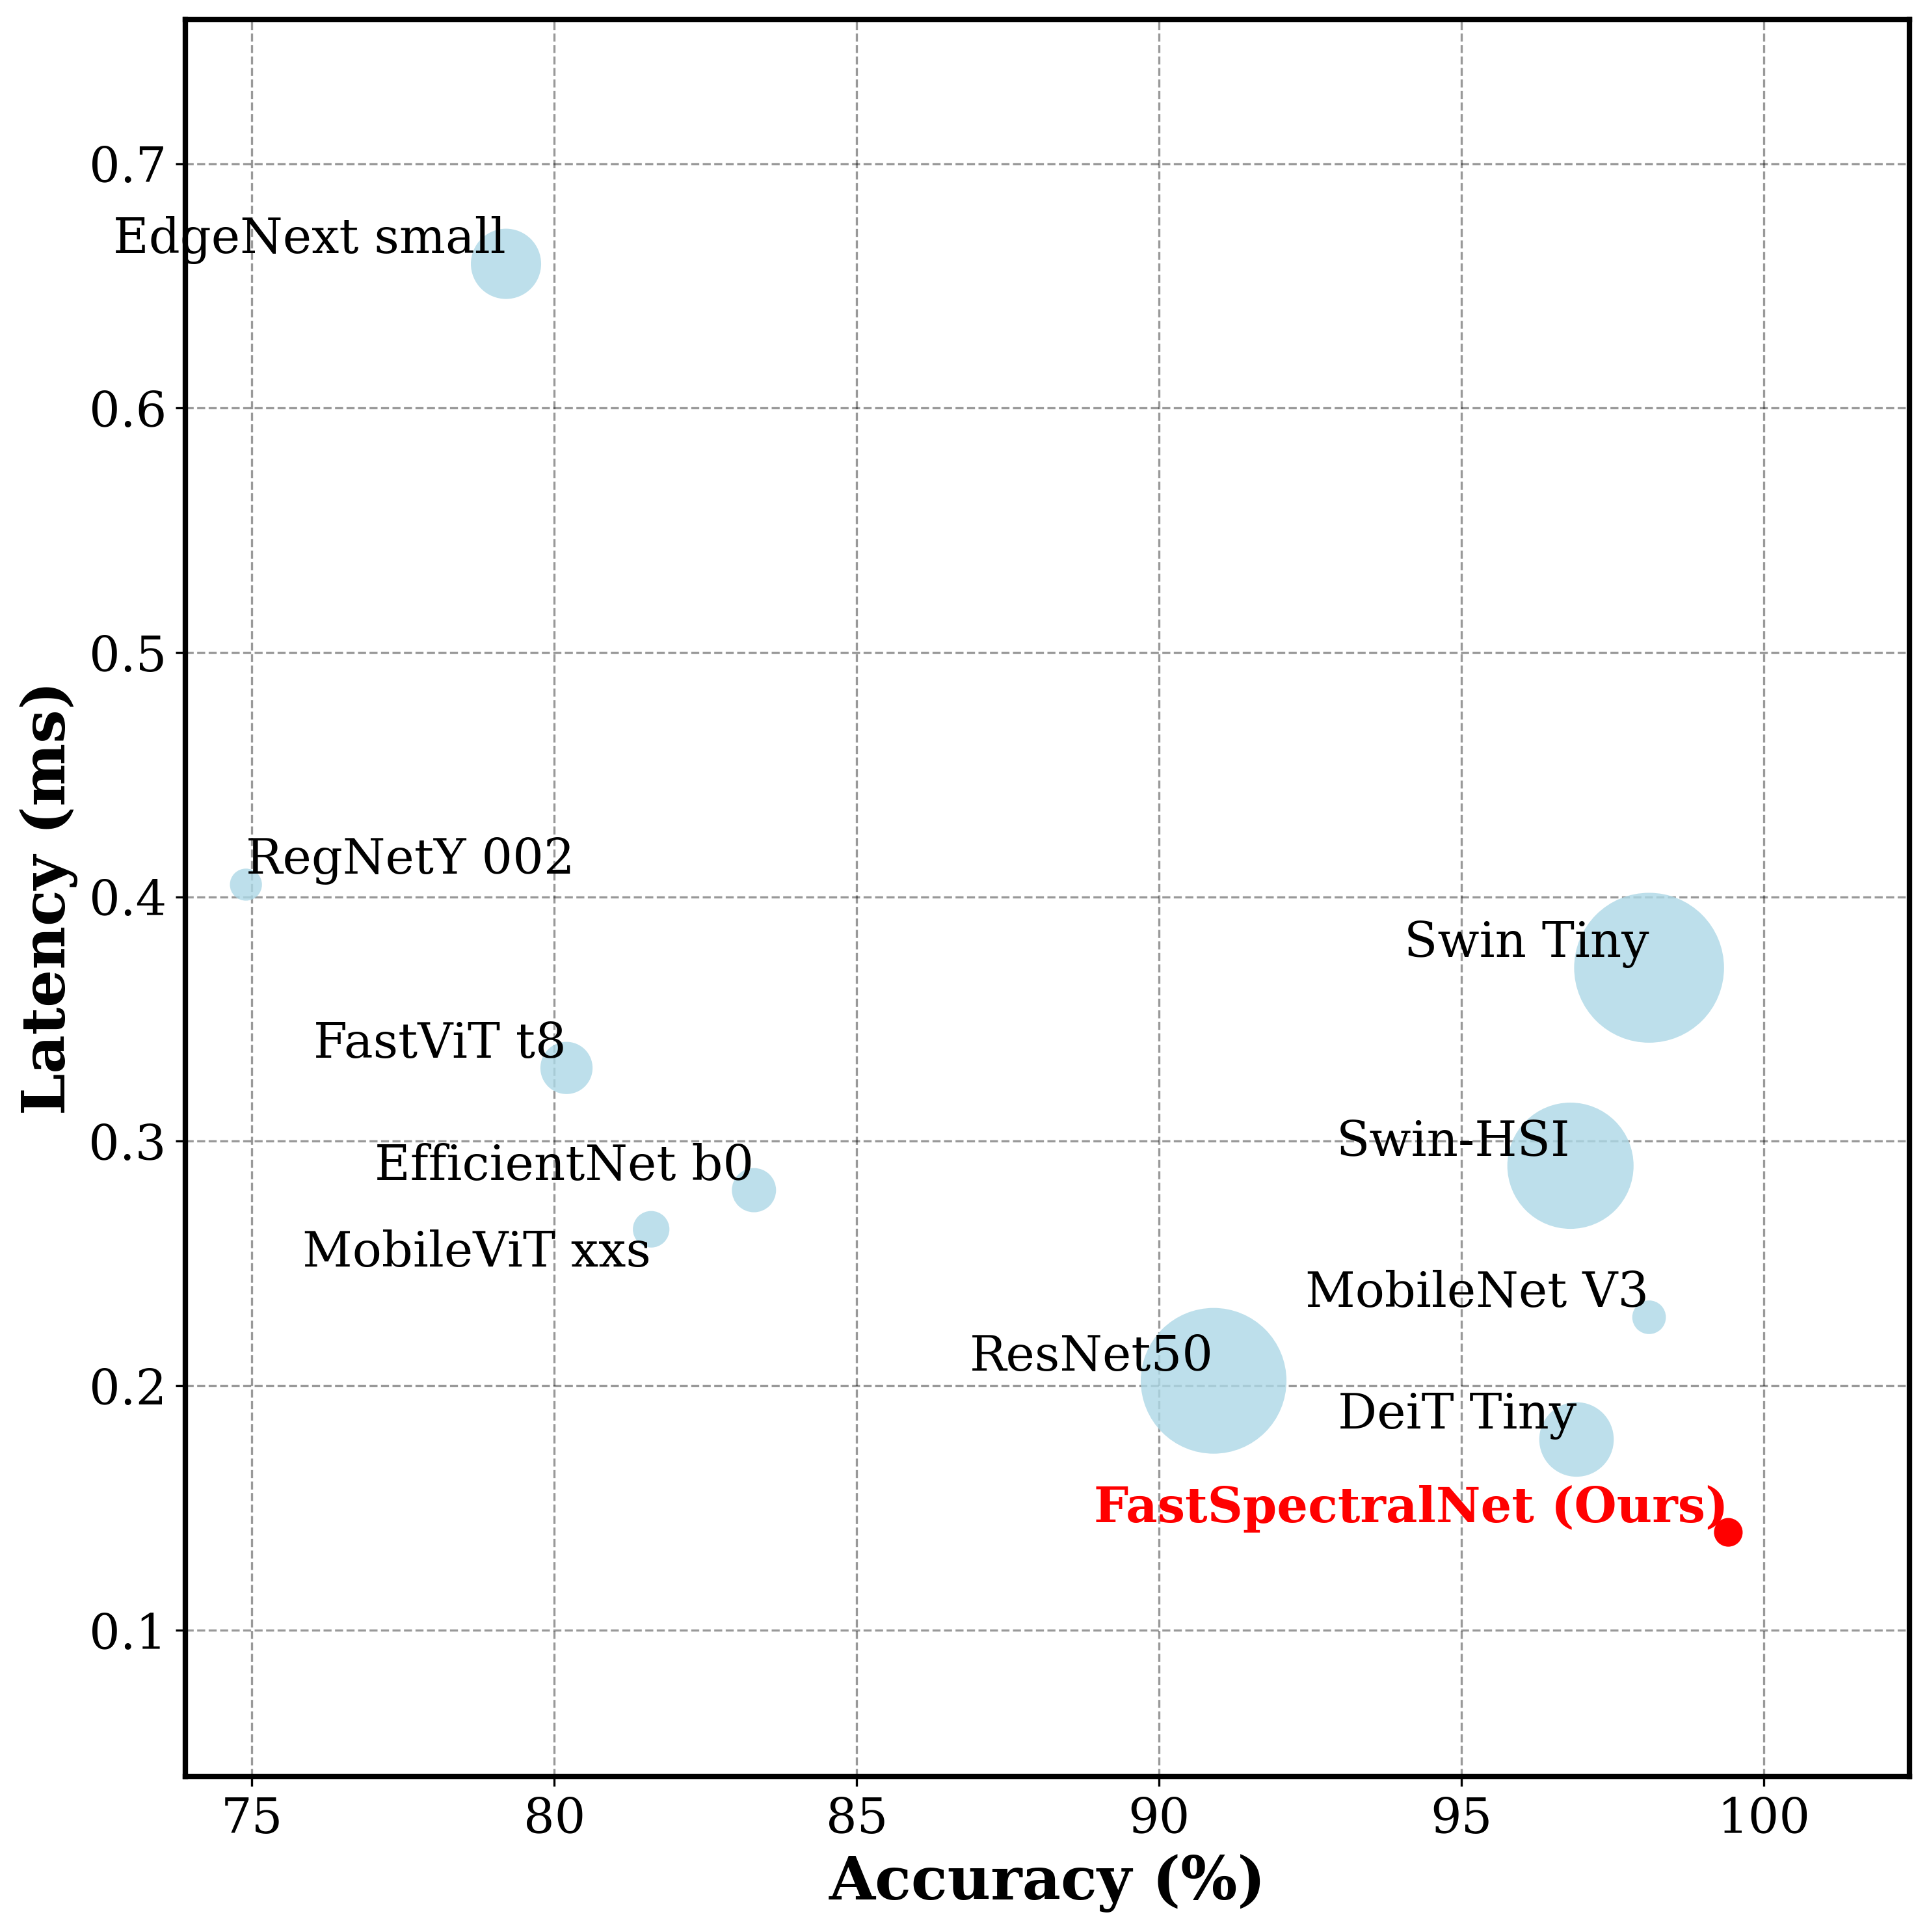

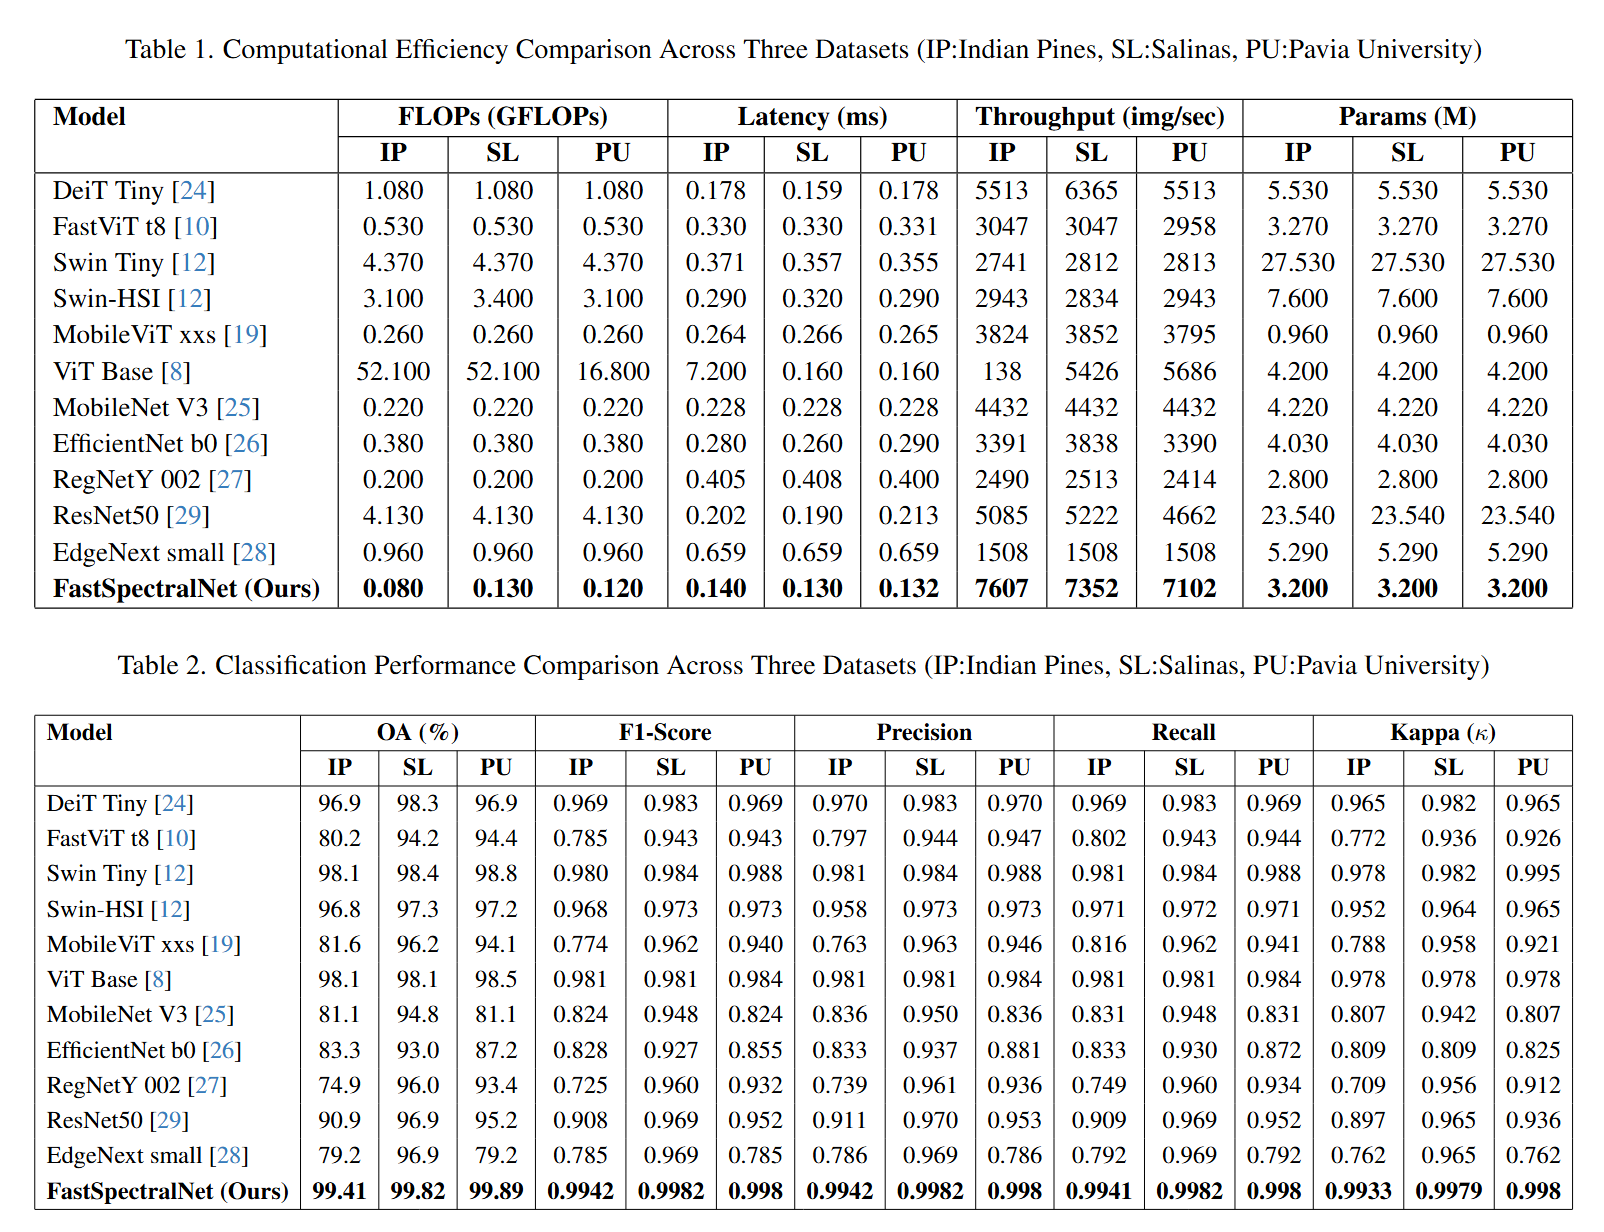